In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import scipy
import random
import argparse

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import Resnet_multiscale_general as net

test_data.shape =  (320, 5121, 2)
model_depends.step_sizes=  [8, 16, 32]
load  original_model_D8_noise0.0.pt
load  original_model_D16_noise0.0.pt
load  original_model_D32_noise0.0.pt
timesteps =  5120
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
96
96


/tmp/ipykernel_1733/1112735433.py:13: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)


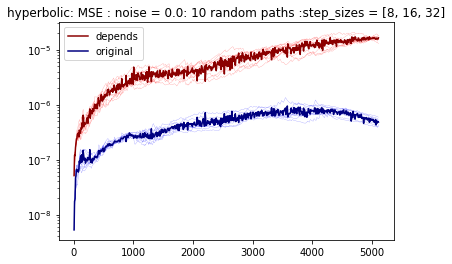

In [31]:


#===========================================================================================================
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(num_lines):
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
    means = np.nanmean(to_ave[:, 1:], axis=0)
    stds = np.nanstd(to_ave[:, 1:], axis=0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)

    return ts[mask], means[mask], stds[mask]
   
#===========================================================================================================

def predict_random_combo(model_depends, models_original, test_data, timesteps = 5000, to_plot=True):
    t = 0
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list_depends = list()
    y_pred_list_original = list()

    indices = np.random.randint(0,len(step_sizes), int(timesteps/min(step_sizes)))
    steps = list()
    for i in range(len(indices)):
        steps.append(step_sizes[indices[i]])
        if sum(steps)>timesteps:
            break
    
    y_pred_list_depends = np.zeros((n_test_points, len(steps)-1, ndim))
    y_pred_list_original = np.zeros((n_test_points, len(steps)-1, ndim))
    y_preds_depends = torch.tensor(test_data[:, 0]).float()
    y_preds_original = torch.tensor(test_data[:, 0]).float()

    for i in range(len(steps)-1):
        this_pick = indices[i]
        this_step_size = steps[i]
        t+= this_step_size
        y_preds_depends = model_depends.forward(y_preds_depends, str(this_step_size))
        y_preds_original = models_original[this_pick].forward(y_preds_original)

        y_pred_list_depends[:,i] = y_preds_depends.detach().numpy()
        y_pred_list_original[:,i] = y_preds_original.detach().numpy()
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list_depends = np.array(y_pred_list_depends)
    y_pred_list_original = np.array(y_pred_list_original)
    
    
    mse_depends = np.mean((y_pred_list_depends - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    mse_original = np.mean((y_pred_list_original - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    
    return y_pred_list_depends, y_pred_list_original, mse_depends, mse_original, t_list
#===========================================================================================================

spacial = False

override_step_list = True
step_sizes = [4, 8, 216]#[4, 8, 216]

small = 8

system = "hyperbolic"
letter = 'a'
noise = 0.0
# timesteps = 5000
if 'KS' in system:
    override_step_list = False
    dt = 0.025
    arch = [512, 2048, 512]
    step_sizes = [1, 6, 36]#[4, 8, 216]
    spacial = True
    
elif 'fluid' in system:
    n_forward = 3
    override_step_list = False
    dt = 0.01
    arch = [22, 256, 22]
    step_sizes  = [1, 4, 16]
    combos_file = "all_combos_fluid4.npy"
    
elif  "VanDerPol" in system:
    smallest_step = 4
    dt = 0.01
    arch = [2, 512, 512, 512, 2]
    step_sizes = [4, 8, 16]
elif "Lorenz" in system:
    smallest_step = 16
    timesteps = 1000
    dt = 0.0005
    arch = [3, 1024, 1024, 1024, 3]
    step_sizes = [16, 32, 64]
    
elif "hyperbolic" in system:
    lr = 1e-4  
    smallest_step = 8
    step_sizes = [8, 16, 32]
    dt = 0.01
    arch = [2, 128, 128, 128, 2] 
elif  "cubic" in system:
    lr = 1e-4  
    smallest_step = 2
    dt = 0.01
    arch = [2, 256, 256, 256, 2] 
    step_sizes = [2, 4, 8]
elif "hopf" in system:
    lr = 1e-4  
    smallest_step = 4
    dt = 0.01
    arch = [3, 128, 128, 128, 3]
    step_sizes = [4, 8, 16]
else:
    print("system not available")
    raise SystemExit()

if small > 0:
    smallest_step = small
    if override_step_list:
        step_sizes = [smallest_step, smallest_step*2, smallest_step*4]
    
n_poss = 1773

# paths
data_dir = os.path.join('../../data/', system,)
model_dir = os.path.join('../../models/', system)


# load data
# train_data = np.load(os.path.join(data_dir, 'train_noise{}.npy'.format(noise)))
# try:
#     val_data = np.load(os.path.join(data_dir, 'val_noise{}.npy'.format(noise)))
# except:
#     #just use training data for all if validation and testing not there
#     print("validation not found, using trainin")
#     val_data= train_data
try:
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
except:
    #just use training data for all if validation and testing not there
    print("testing not found, using training ")
    test_data=train_data


n_test_points, _, ndim = test_data.shape

# n_train = train_data.shape[0]
# n_val = val_data.shape[0]
n_test = test_data.shape[0]

# print("train_data shape = ", train_data.shape)
# print("val_data shape = ", val_data.shape)
print("test_data.shape = ", test_data.shape)


#load depend model
model_name = 'model_{}_depends_stepsize{}_noise{}_{}.pt'.format(system, smallest_step, noise, letter)
model_depends = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
model_depends.device = 'cpu'

print("model_depends.step_sizes= ", model_depends.step_sizes)
for step_size in model_depends.step_sizes:
    model_depends._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()

    
#load original models
# load models
models_original = list()
for step_size in model_depends.step_sizes:
    model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
    print("load ", model_name)
    try:
        try:
            models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
        except:
            try:
                model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
            except:
                model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        print("done loading at {}".format(step_size))
        break
        

to_plot = False
timesteps = test_data.shape[1] - 1
#less for Lorenz
if "Lorenz" in system:
    timesteps = 1000
    
elif "KS" in system:
    timesteps = 1000
    
print("timesteps = ", timesteps)

        
num_lines = 10
mse_list_depends = list()
mse_list_original = list()
t_list_list = list()
path_list = list()
y_pred_list_depends = list()
y_pred_list_original = list()


#train all the random lines of both models
for i in range(num_lines):
    print("i = ", i)

    y_preds_random_depends, y_preds_random_original, mse_random_depends, mse_random_original, t_list_random = predict_random_combo(model_depends, models_original, test_data, timesteps = timesteps, to_plot=False)
    y_pred_list_depends.append(y_preds_random_depends[0,:])
    y_pred_list_original.append(y_preds_random_original[0,:])
    mse_list_depends.append(mse_random_depends)
    mse_list_original.append(mse_random_original)
    t_list_list.append(t_list_random)

#find the average paths for both methods
ts_depends, means_depends, stds_depends = find_ave_random_paths(t_list_list, mse_list_depends)
ts_original, means_original, stds_original = find_ave_random_paths(t_list_list, mse_list_original)


#####################################################################################################
#start of the plotting code

# graph the mse both themods with a random line for each trial and thicker line for average of mse
plt.figure()
for i in range(len(mse_list_depends)):
    plt.semilogy(t_list_list[i], mse_list_depends[i], 'r', linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list[i], mse_list_original[i], 'b', linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
plt.semilogy(ts_original, means_original[:,0], color='navy', label="original")
plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
plt.show()




In [32]:
t_list_list0 = t_list_list
mse_list_depends0 = mse_list_depends
mse_list_original0 = mse_list_original
ts_depends0 = ts_depends
ts_original0 = ts_original
means_depends0 = means_depends
means_original0 = means_original

In [36]:
colors=plt.cm.rainbow(np.linspace(0, 1, 8))
print(colors)

[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.17647059e-01 4.29120609e-01 9.75511968e-01 1.00000000e+00]
 [7.25490196e-02 7.82927610e-01 9.00586702e-01 1.00000000e+00]
 [3.54901961e-01 9.74138602e-01 7.82927610e-01 1.00000000e+00]
 [6.45098039e-01 9.74138602e-01 6.22112817e-01 1.00000000e+00]
 [9.27450980e-01 7.82927610e-01 4.34676422e-01 1.00000000e+00]
 [1.00000000e+00 4.29120609e-01 2.19946358e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]


Text(0.5, 1.0, 'Hyperbolic 3200 : Increasing noise')

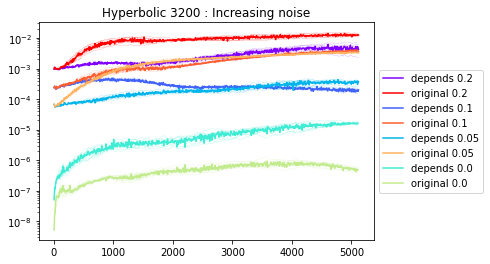

In [42]:
# graph the mse both themods with a random line for each trial and thicker line for average of mse

colors=plt.cm.rainbow(np.linspace(0, 1, 9))

plt.figure()
for i in range(len(mse_list_depends2)):
    plt.semilogy(t_list_list2[i], mse_list_depends2[i], color=colors[0], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list2[i], mse_list_original2[i], color = colors[-1], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends2, means_depends2[:,0], color=colors[0], label="depends 0.2")
plt.semilogy(ts_original2, means_original2[:,0], color=colors[-1], label="original 0.2")

# graph the mse both themods with a random line for each trial and thicker line for average of mse
# plt.figure()
for i in range(len(mse_list_depends1)):
    plt.semilogy(t_list_list1[i], mse_list_depends1[i], color=colors[1], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list1[i], mse_list_original1[i], color=colors[-2], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends1, means_depends1[:,0], color=colors[1], label="depends 0.1")
plt.semilogy(ts_original1, means_original1[:,0], color=colors[-2], label="original 0.1")
# plt.legend()

for i in range(len(mse_list_depends05)):
    plt.semilogy(t_list_list05[i], mse_list_depends05[i], color=colors[2], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list05[i], mse_list_original05[i], color=colors[-3], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends05, means_depends05[:,0], color=colors[2], label="depends 0.05")
plt.semilogy(ts_original05, means_original05[:,0], color=colors[-3], label="original 0.05")

for i in range(len(mse_list_depends0)):
    plt.semilogy(t_list_list0[i], mse_list_depends0[i], color=colors[3], linewidth = 0.25, alpha = 0.5)
    plt.semilogy(t_list_list0[i], mse_list_original0[i], color=colors[-4], linewidth = 0.25, alpha=0.5)

plt.semilogy(ts_depends0, means_depends0[:,0], color=colors[3], label="depends 0.0")
plt.semilogy(ts_original0, means_original0[:,0], color=colors[-4], label="original 0.0")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Hyperbolic 3200 : Increasing noise")
# plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
# plt.show()